## Sport challenges - Recommender System

#### Utilizzando un dataset relativo ai dati di allenamento di vari utenti sparso, senza informazioni relative a possibili legami tra i vari utenti, ho optato per un approccio Content-based. In questo progetto si partirà quindi dalla somiglianza tra le varie tipologie di allenamento, effettuate dai vari utenti, per arrivare poi a stabilire relazioni di somiglianza tra gli interessi, in termini di allenamento, degli utenti stessi. A partire quindi dal dataset principale si arriverà alla definizione di un Sistema Di Raccomandazione che, a partire da un utente, restituirà la lista degli utenti a lui più vicini in termini di tipologie di allenamento.

In [1]:
!pip3 install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import datetime
import haversine as hs
import datetime
import statistics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

#### Leggo dal dataset ( https://sites.google.com/eng.ucsd.edu/fitrec-project/home ) i dati relativi a tutte le sessioni di allenamento. Ho optato per l'utilizzo del dataset endomondoHR_proper.json in quanto rappresenta un giusto compromesso tra la versione completa e quella semplificata / normalizzata.

In [3]:
data = []
with open('./endomondoHR_proper.json') as f:
    for l in f:
        data.append(eval(l))

#### Funzione che effettua il calcolo della distanza totale di un singolo allenamento (km) a partire dalla lista delle coordinate

In [4]:
def calculate_tranining_distance(single_training):
    total_distance = 0
    
    for index in range(len(single_training['latitude'])-2):
        lat1 = single_training['latitude'][index]
        lon1 = single_training['longitude'][index]
        lat2 = single_training['latitude'][index+1]
        lon2 = single_training['longitude'][index+1]

        loc1=(lat1,lon1)
        loc2=(lat2,lon2)
        total_distance = total_distance + hs.haversine(loc1,loc2)
        
    return int(total_distance)

#### Funzione che effettua il calcolo della durata totale del singolo allenamento (minuti) a partire dalla lista di timestamp

In [6]:
def calculate_training_duration(single_training):
    start = single_training['timestamp'][0]
    finish = single_training['timestamp'][-1]
    
    start_date = datetime.datetime.fromtimestamp(start)
    finish_date = datetime.datetime.fromtimestamp(finish)
    
    difference = finish_date - start_date
    seconds_in_day = 24 * 60 * 60
    datetime.timedelta(0, 8, 562000)
    
    return int(divmod(difference.days * seconds_in_day + difference.seconds, 60)[0])

#### Funziona che effettua il calcolo della velocità media dell'allenamento (km/h) a partire dalla distanza totale e il tempo impiegato

In [7]:
def calculate_avg(distance, duration):
    if(duration > 0):
        return int((distance / (duration/60)))
    return 0

#### Funzione che effettua il calcolo della media dei battiti cardiaci a partire dalla lista contenente i campioni di battiti rilevati durante l'allenamento

In [8]:
def calculate_hear_rate_avg(single_training):
    return int(statistics.median(single_training['heart_rate']))

#### Funzione che effettua il calcolo del dislivello totale dell'allenamento a partire dalla lista contenente i campioni dell'altitude rilevata

In [9]:
def calculate_altitude_difference(single_training):
    total_altitude_difference = 0
    
    for index in range(len(single_training['altitude'])-2):
        if(single_training['altitude'][index + 1] >= single_training['altitude'][index]):
            total_altitude_difference = total_altitude_difference + (single_training['altitude'][index + 1] - single_training['altitude'][index])
        else:
            total_altitude_difference = total_altitude_difference + (single_training['altitude'][index] - single_training['altitude'][index + 1])
        
    return int(total_altitude_difference)

#### Funzione che trasforma la descrizione testuale del sesso in 1 (uomo) e 2 (donna)

In [10]:
def transform_sex_value(single_training):
    if(single_training['gender'] == 'male'):
        return 1
    else:
        return 2

#### Funzione che trasforma la descrizione testuale dello sport in 1 (bike) e 2 (run)

In [11]:
def transform_sport_value(single_training):
    if single_training['sport'] == 'bike' or single_training['sport'] == 'bike (transport)':
        return 1
    else:
        return 2

#### A partire dal dataset iniziale, viene creata una nuova lista contenente una versione rielaborata dei dati degli allenamenti (calcolo della distanza totale, calcolo della velocità media, calcolo della frequenza cardiaca media, calcolo del dislivello, calcolo della durata totale) in modo tale da consentire una migliore fruzione ed analisi delle informazioni contenute.

In [12]:
reworkedData = []
for i in data:
        reworkedItem = {}
        reworkedItem['userId'] = i['userId']
        reworkedItem['id'] = i['id']
        reworkedItem['gender'] = transform_sex_value(i)
        reworkedItem['sport'] = transform_sport_value(i)
        reworkedItem['distance'] = calculate_tranining_distance(i)
        reworkedItem['duration'] = calculate_training_duration(i)
        reworkedItem['avg'] = calculate_avg(reworkedItem['distance'], reworkedItem['duration'])
        reworkedItem['heart_rate_avg'] = calculate_hear_rate_avg(i)
        reworkedItem['altitude_difference'] = calculate_altitude_difference(i)
        reworkedData.append(reworkedItem)

#### A partire dalla nuova lista creata, si genera un nuovo dataset corrispondente

In [14]:
reworkedCompleteDataSet = pd.DataFrame(reworkedData)

# Elimino le row contenenti dati degli allenamenti non significativi
reworkedCompleteDataSet = reworkedCompleteDataSet[(reworkedCompleteDataSet==0).sum(axis=1)/len(reworkedCompleteDataSet.columns) <= 0.000]

# Per facilitare le operazioni successive, trasformo in stringa tutti i dati contenuti nel dataset
reworkedCompleteDataSet = reworkedCompleteDataSet.astype(str)

reworkedCompleteDataSet.head(5)

,userId,id,gender,sport,distance,duration,avg,heart_rate_avg,altitude_difference
0,10921915,396826535,1,1,52,126,24,153,818
1,10921915,392337038,1,1,32,74,25,148,454
2,10921915,389643739,1,1,45,112,24,141,681
3,10921915,386729739,1,1,32,75,25,148,479
4,10921915,383186560,1,1,11,22,30,170,196


#### Funzione che associa ad ogni utente una stringa rappresentante tutti i dati relativi agli allenamenti da lui effettuati.

In [15]:
def getTrainingString(trainingData, usersDictionary):
    oldString = usersDictionary[trainingData['userId']]
    if(oldString != ''):
        newString = oldString +' '+ trainingData['heart_rate_avg']+ '-' +trainingData['gender']+ '-' + trainingData['sport']+ '-' + trainingData['distance']+ '-' + trainingData['duration']+ '-' + trainingData['avg']+ '-' + trainingData['altitude_difference']
    else:
        newString = trainingData['heart_rate_avg']+ '-' +trainingData['gender']+ '-' + trainingData['sport']+ '-' + trainingData['distance']+ '-' + trainingData['duration']+ '-' + trainingData['avg']+ '-' + trainingData['altitude_difference']
    return newString

#### Si crea ora un dictionary contenente la lista degli utenti con associata la stringa corrispondente agli allenamenti fatti.

In [16]:
usersDictionary = {}

for index, row in reworkedCompleteDataSet.iterrows():
    if(row['userId'] not in usersDictionary):
        usersDictionary.update({row['userId']: ''})
        usersDictionary[row['userId']] = getTrainingString(row,usersDictionary)
    else:
        usersDictionary[row['userId']] = getTrainingString(row,usersDictionary)

#### Creo ora un nuvo dataset corrispondente al dictionary sopra citato. Tale dataset conterrà quindi la lista degli utenti con associata la stringa corrispondente ai dati degli allenamenti effettuati. Viene implementata dunque questa trasformazione dei dati per consentire la successiva gestione di tali informazioni tramite TFIDF e la cosine similarity. Si andrà quindi a verificare la "vicinanza" tra gli allenamenti effettuati da un utente con quelli di un altro tramite il tipico approccio utilizzato per i documenti testuali: gli allenamenti di ogni utente vengono difatti interpretati come un singolo documento composto da più frasi (dati dei singoli allenamenti).

In [17]:
usersJson = []

for userId,training_data in usersDictionary.items():
    usersJson.append({
        'userId': userId,
        'training_data': training_data
    })
    
usersTrainingDataSet = pd.DataFrame(usersJson)
usersTrainingDataSet.head()

,userId,training_data
0,10921915,153-1-1-52-126-24-818 148-1-1-32-74-25-454 141...
1,4969375,115-1-2-8-64-7-761 144-1-2-14-70-12-205 128-1-...
2,430859,130-1-1-37-104-21-226 137-1-1-59-168-21-617 13...
3,279317,151-2-2-5-28-10-84 115-2-1-16-47-20-339 129-2-...
4,3905196,141-1-2-14-79-10-713 140-1-2-12-63-11-652 137-...


#### Applico la funzione peso TF-IDF al dataset usersTrainingDataSet ed effettuo il calcolo della cosine similarity

In [18]:
tfidf = TfidfVectorizer(stop_words='english')
usersTrainingDataSet['training_data'] = usersTrainingDataSet['training_data'].fillna('')
overview_matrix = tfidf.fit_transform(usersTrainingDataSet['training_data'])

similarity_matrix = linear_kernel(overview_matrix,overview_matrix)

mapping = pd.Series(usersTrainingDataSet.index,index = usersTrainingDataSet['userId'])

#### Funzione che implementa la ricerca degli utenti con gli allenamenti più simili a quelli dell'utente passato come parametro

In [23]:
def recommend_training_based_on_plot(training_input):
    
    training_index = mapping[training_input]
    similarity_score = list(enumerate(similarity_matrix[training_index]))
    
    # Ordina in ordine decrescente in base al punteggio di somiglianza dell'utente immesso con tutti gli altri utenti
    similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
    
    # Ottieni i punteggi dei primi 10 utenti più simili ignorando il primo
    similarity_score = similarity_score[1:10]
    
    # Restituisci gli id degli utenti utilizzando la similarity_score
    training_indices = [i[0] for i in similarity_score]
    
    return (usersTrainingDataSet['userId'].iloc[training_indices])

In [27]:
recommend_training_based_on_plot('34269')

609     2894897
263     3276737
155     8276277
56      3559941
550     6601602
1009     212295
325     2974312
408     7313790
642     1842744
Name: userId, dtype: object

#### Verifico ora che l'andamento dei dati di allenamento sia simile tra l'utente selezionato e i suoi vicini rilevati dal sistema. Per fare questo prendo, per ogni utente, la lista dei valori numerici corrispondenti ai dati di allenamento e li sommo per ogni allenamento. In questo modo avrò, per ogni allenamento, un campione pari alla somma dei valori numerici dei dati relativi allo stesso. Disegno poi un grafico di andamento per ciascun utente e confronto i risultati ottenuti

In [30]:
def getUserTrainingValueList(userId):
    valueList = []
    currentValue = ''
    for i in usersDictionary[userId]:
        if(i != ' ' and i != '-'):
            currentValue = currentValue + i
        if(i == ' '):
            valueList.append(currentValue)
            currentValue = ''
    return valueList

In [31]:
recommend_training_based_on_plot('34269')

609     2894897
263     3276737
155     8276277
56      3559941
550     6601602
1009     212295
325     2974312
408     7313790
642     1842744
Name: userId, dtype: object

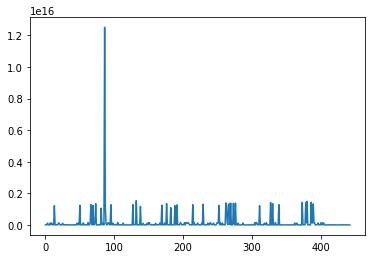

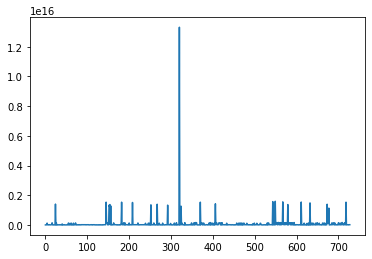

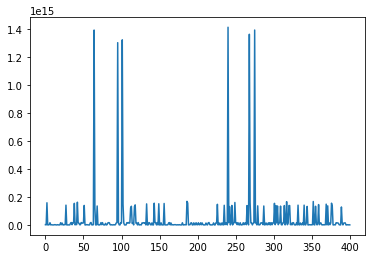

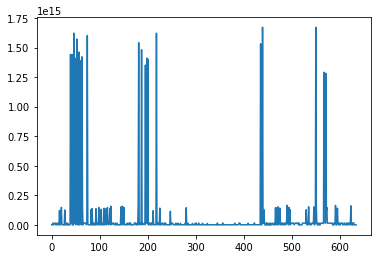

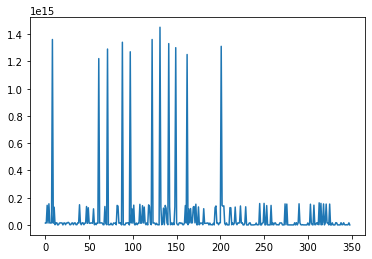

In [32]:
from matplotlib import pyplot as plt

userTraningValues = [ int(x) for x in getUserTrainingValueList('34269') ]
plt.plot(userTraningValues)
plt.show()

userTraningValues2 = [ int(x) for x in getUserTrainingValueList('2894897') ]
plt.plot(userTraningValues2)
plt.show()

userTraningValues3 = [ int(x) for x in getUserTrainingValueList('3276737') ]
plt.plot(userTraningValues3)
plt.show()

userTraningValues4 = [ int(x) for x in getUserTrainingValueList('8276277') ]
plt.plot(userTraningValues4)
plt.show()

userTraningValues5 = [ int(x) for x in getUserTrainingValueList('3559941') ]
plt.plot(userTraningValues5)
plt.show()

In [34]:
recommend_training_based_on_plot('2358')

404     8875079
50        56291
359     2898275
1050    3191096
325     2974312
462     4362441
724     6796415
879     7654809
773     4146688
Name: userId, dtype: object

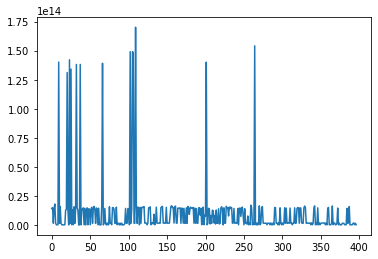

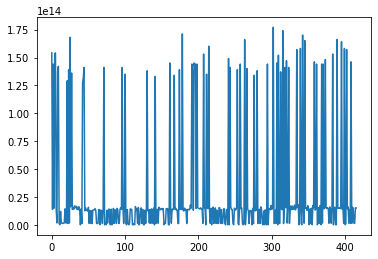

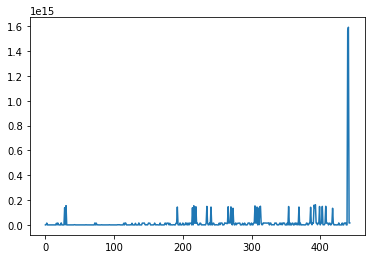

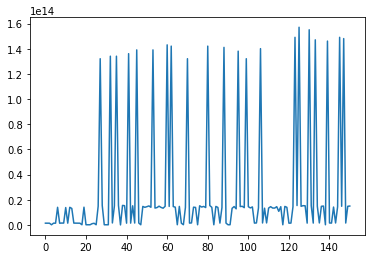

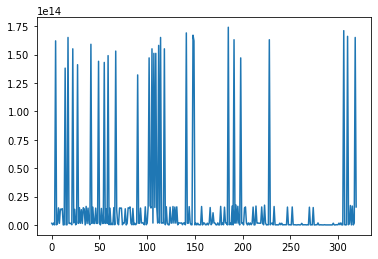

In [35]:
from matplotlib import pyplot as plt

userTraningValues = [ int(x) for x in getUserTrainingValueList('2358') ]
plt.plot(userTraningValues)
plt.show()

userTraningValues2 = [ int(x) for x in getUserTrainingValueList('8875079') ]
plt.plot(userTraningValues2)
plt.show()

userTraningValues3 = [ int(x) for x in getUserTrainingValueList('56291') ]
plt.plot(userTraningValues3)
plt.show()

userTraningValues4 = [ int(x) for x in getUserTrainingValueList('2898275') ]
plt.plot(userTraningValues4)
plt.show()

userTraningValues5 = [ int(x) for x in getUserTrainingValueList('3191096') ]
plt.plot(userTraningValues5)
plt.show()

Come si evince dai risultati ottenuti, gli utenti suggeriti restituiti hanno dei dati di allenamento discretamente simili a quelli dell'utente passato come parametro alla funzione di raccomandazione. Se ritenuto quanto fatto effettivamente corretto, uno sviluppo futuro (magari per il progetto di Machine Learning) potrebbe essere quello di andare ad eliminare il rumore dal dataset e, soprattutto, una volta individuata la lista di utenti simili, suggerire la lista di allenamenti, effettuati da ogni utente simile restituito dal sistema, nei quali le performance dell'utente selezionato possano essere migliori.